## **_micrograduate_**: from backprop to GPT!

### 1. **micrograd**: implementing an autograd engine

We'll begin by implementing **micrograd**: an autograd engine. "autograd" stands for automatic backpropagation (**backprop**), where **backprop** refers to an algorithm that allows you to efficiently evaluate the gradient of an error or **loss** function with respect to (**w.r.t.**) the weights and biases of a neural network (**nn**). This allows us to iteratively tune these parameters, minimize the **loss** and therefore improve the accuracy of the network. **backprop** is at the mathematical core of any modern deep neural network library, like pytorch or jax. **micrograd**'s functionality is best illustrated by an example.

In [1]:
from micrograd.engine import Value

a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
print(f'{g.data:.4f}, the outcome of this forward pass')
g.backward()
print(f'{a.grad:.4f}, i.e. the numerical value of dg/da')
print(f'{b.grad:.4f}, i.e. the numerical value of dg/db')

24.7041, the outcome of this forward pass
138.8338, i.e. the numerical value of dg/da
645.5773, i.e. the numerical value of dg/db


You'll see that **micrograd** allows us to build out mathematical expressions. Here, we have an expression that we're building out where you have two inputs `a` and `b` whose values have been wrapped into a `Value` object that we are going to build out as part of **micrograd**. In this example, we build a mathematical expression graph. `a` and `b` are transformed into `c` and `d`, and eventually into `e`, `f` and `g` through some intermediary operations such as addition (`+`), multiplication (`*`), exponentiation to a constant power (e.g. `b**3`). Other operations include
offsetting by one, negation, squashing at zero, squaring, division, etc. And so from these values micrograd will, in the background, build out a mathematical expression graph. It will know, for example, that `c` is also a value but also a result of the addition operation of two child value nodes `a` and `b`, to which it will maintain pointers. So, we'll basically know exactly how all this operations graph is laid out. Then, we can do a forward pass (`a`, `b` -> ... -> `g`), but  also initiate the backward pass that constitutes **backprop** by calling `backward` at node `g`, `g.backward()`. What backpropagation is going to do is start at `g` and it's going to go backwards through that expression graph and it's going to recursively apply the chain rule from calculus. This allows it to evaluate the derivative of `g` with respect to all the internal nodes, like `e`, `d` and `c`, but also with respect to the inputs `a` and `b`. Then we can actually query this derivative of `g` with respect to, for example, a (`a.grad`) or the derivative of `g` with respect to `b` (`b.grad`). The values of these `grad` attributes tell us how `a` and `b` are affecting `g` through this mathematical expression. If we slightly nudge `a` and make it slightly larger, `a.grad == 138.8338` is telling us that `g` will grow and that the slope of that growth is going to be equal to that number. Similarly, the slope of growth of `g` with respect to a slight positive nudge of `b` is going to be `645.5773`. a **nn** is a function that takes in inputs and weights and returns an output: `F(in, w) = out`. **micrograd** will help you understand **nn**s at such a fundamental level by disregarding non-essential elements (e.g. tensors) that you would otherwise encounter in practice, production, etc. **micrograd** is all you need in order to understand the basics. Everything else is just efficiency. Now, let's dive right in and start implementing!

First, we must make sure that we develop a very good, intuitive understanding of what a derivative is and exactly what information it gives us.

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib ipympl

In [3]:
def y(x):
    return 3*x**2 - 4*x + 5

In [4]:
y(3.0)

20.0

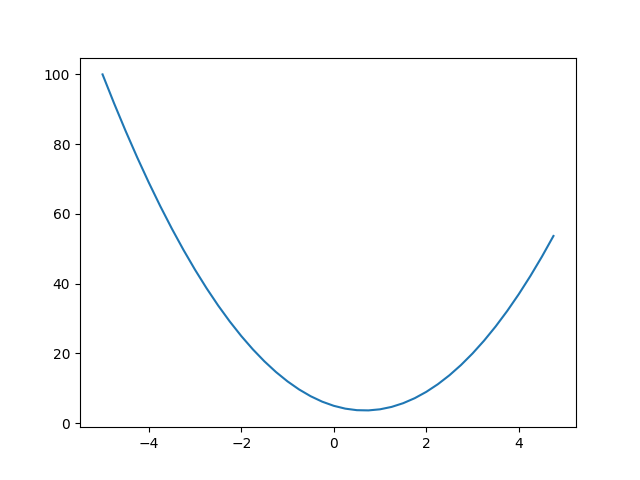

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = y(xs)
plt.figure()
plt.plot(xs, ys);

Above, we plotted a parabola. Now, to think through what is the derivative of this function at any point x is, let's from the equivalent definition of [what it means for a function to be differentiable](https://en.wikipedia.org/wiki/Derivative#Definition). Understanding the derivative boils down to finding how a such a function `f` responds to a slight nudge of a small number `h` of its input `x`. Meaning, with what sensitivity does it respond? Does the value go up or down? Or, to be more precise, what is the slope at that point `x`? Is it positive or negative? This exact amount we are looking for is given to us by the limit equation that we can very simply approximate numerically with a small enough `h` value, as follows.

In [6]:
h = 0.00000001
x = 3.0  # try -3.0, 2/3, etc.
(y(x + h) - y(x))/h

14.00000009255109

Now, with a more complex example, to start building an intuition about the derivative, let's find out the derivatives of `d` w.r.t. `a`, `b` and `c`.

In [7]:
h = 0.00000000000001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a += h  # try nudging `b` or `c` instead to see what happens
d2 = a*b + c
print(f'd1: {d1}')
print(f'd2: {d2}')
print(f'slope: {(d2 - d1)/h}')

d1: 4.0
d2: 3.99999999999997
slope: -3.019806626980426


We now have some intuitive sense of what a derivative is telling us about a function. Now, let's move unto **nn** that are much more massive mathematical expressions. To do so easily, we must build some infrastructure.

In [8]:
class Value:
    def __init__(self, data, prev=(), op='', label='',):
        self.data = data
        self.prev = set(prev)
        self.op = op
        self.label = label
        self.grad = 0.
    def __repr__(self):
        return f"{self.__class__.__name__}(data='{self.data}'" + (f", label='{self.label}')" if self.label else ')')
    def __add__(self, other):
        return self.__class__(
            data=(self.data + other.data),
            prev=(self, other),
            op='+',
        )
    def __radd__(self, other):  # other + self
        return self + other
    def __mul__(self, other):
        return self.__class__(
            data=(self.data * other.data),
            prev=(self, other),
            op='*',
        )
    def __rmul__(self, other):  # other * self
        return self * other
    def __neg__(self): # -self
        return self * -1
    def __sub__(self, other): # self - other
        return self + (-other)
    def tanh(self):
        return self.__class__(
            data=math.tanh(self.data),
            prev=(self,),
            op='tanh',
        )
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label='f')
def forward_pass(label=False):
    d = a*b
    e = d + c
    L = e*f
    if label:
        d.label = 'd'
        e.label = 'e'
        L.label = 'L'
    return L
L = forward_pass(label=True)
L

Value(data='-8.0', label='L')

In [9]:
L.prev

{Value(data='-2.0', label='f'), Value(data='4.0', label='e')}

In [10]:
L.op

'*'

A `Value` object acts as a value holder and it can also perform operations (`+`, etc.) with other objects to produce new instances. Each such instance holds:
- some value `data`
- the operation `op` that produced it (e.g. `+`)
- its children `prev` a tuple of the `Value` instances that produced it
- its gradient `grad` that represents the derivative of some value (e.g. `L`)  w.r.t. it
- its backward

To recap what we have done so far: we have built scalar-valued mathematical expression graphs using operations such as addition and multiplication. To see such a graph that each `Value` object represents, let's define a visualization function `draw()` and call it on a `Value` object, e.g. `L`.

In [11]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw(root):
    dot = Digraph(format='svg', graph_attr={
                  'rankdir': 'LR'})  # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (
            n.label, n.data, n.grad), shape='record')
        if n.op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n.op, label=n.op)
            # and connect this node to it
            dot.edge(uid + n.op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)
    return dot


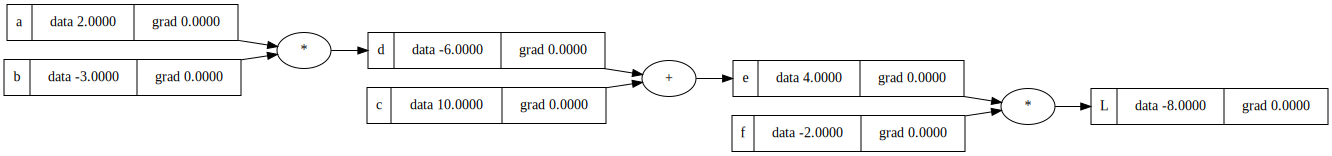

In [12]:
draw(L)

The above graph represents a forward pass. As a reminder, each `grad` attribute refers to how much each nudge of the value of a node (e.g. `c`) contributes to the output value `L`. Let's now, fill in those gradients by doing **backprop** manually. Starting at `L` (the end of the graph), we ask what is the derivative of `L` w.r.t. itself? Since `f(L) = L`, it is `(f(L + h) - f(L))/h = (L + h - L)/h`, ...

In [13]:
h = 0.001
L.grad = ((L.data + h) - L.data)/h
L.grad

1.000000000000334

...which equals `1`! Now, moving backwards in the graph, what about the derivative of `L` w.r.t. `e`, for example? Let's do the same and find out. This time `L(e) = e*f`. And so, `dL/de = (L(e + h) - L(e))/h = ((e + h)*f - e*f)/h = (e*f + h*f - e*f)/h = f`. Similarly, `dL/df = e`. Therefore:

In [14]:
e.grad = f.data
f.grad = e.data
print(e.grad)
print(f.grad)

-2.0
-7.0


Now, we will find `dL/dc`, which basically constitutes the crux of **backprop** and the most important node to understand. So, pay attention!
How do we find the derivative of `L` w.r.t. `c`? Very intuitively, by knowing `L` is sensitive to `d` (`dL/de`) and how `d` is sensitive to `c` (`de/dc`), we should be able to somehow put this information together and get our result. We know the former. Whereas, for the latter: `e(c) = c + d` and so `de/dc = (e(c + h) - e(c))/h = ((c + h + d) - (c + d))/h = 1` and similarly, `de/dd = 1`. That "somehow" is the [chain rule](https://en.wikipedia.org/wiki/Chain_rule), according to which: `dL/dc = (dL/de) * (de/dc)`. For us, this means:

In [15]:
c.grad = e.grad * 1.0
c.grad

-2.0

To sum up:
- we want `dL/dc`
- we know `dL/de`
- we know `de/dc`
- we apply the chain rule: `dL/dc = (dL/de) * (de/dc) = (dL/de) * 1 = dL/de`
- similarly: `dL/dd = (dL/de) * (de/dd) = (dL/de) * 1 = dL/de`

Easy! Notice the fact that `de/dc = de/dd = 1`. This equality verifies the fact that the addition operator (`+`) just acts as a router, merely distributing the derivative of the result (e.g. `dL/de`) backwards, through all the children nodes (e.g. `c` and `d`), without unperturbed.

To complete this session of manual **backprop**, we are going to recurse this process and re-apply the chain rule all the way back to the input nodes, `a` and `b`. Thus, we are looking for `dL/da` and `dL/db`, meaning:
- `dL/da = (dL/dd) * (dd/da)`
- `dL/db = (dL/dd) * (dd/db)`

We already know that:

In [16]:
f'dL/dd = dL/de = {e.grad}'

'dL/dd = dL/de = -2.0'

But, what about `dd/da` and `dd/db`? Let's derive them, the same way we did with `de/dc`:
- `dd/da = (d(a + h) - d(a))/h = (((a + h) * b) - (a * b))/h = (a*b + h*b - a*b)/h = h*b/h = b`
- `dd/db = a`

Therefore:

In [17]:
a.grad = e.grad * b.data
b.grad = e.grad * a.data
print(a.grad)
print(b.grad)

6.0
-4.0


If we re-draw our computational graph, we get:

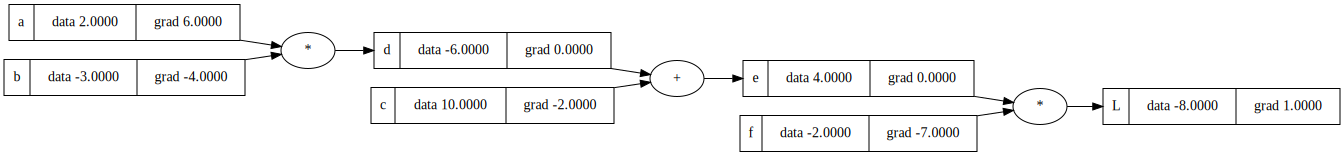

In [18]:
draw(L)

And that's what **backprop** is! Just the recursive application of the chain rule backwards through the computational graph for calculating the gradient of a **loss** value (`L`) w.r.t. all other values that produced it (`a`, `b`, etc.). The purpose being, to be able to use the gradient values to nudge the **loss** value: optimization step. This process goes as follows:
- to _increase_ `L`, let each value follow the gradient in the _positive_ direction
- to _decrease_ `L`, let each value follow the gradient in the _negative_ direction

Running the following example should increase the value of `L`:

In [19]:
Lold = L.data
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad
e.data += 0.01 * e.grad
f.data += 0.01 * f.grad
L = forward_pass()
print(f'old L: {Lold}')
print(f'new L: {L.data}')

old L: -8.0
new L: -7.695431999999999


You just learned how to apply one optimization step! Optimization is fundamental when it comes to training **nn**s, as you will see... So, eventually we want to build up a level of understanding for training such multilayer perceptrons (**mlp**s), as they are called.

#### MLP example

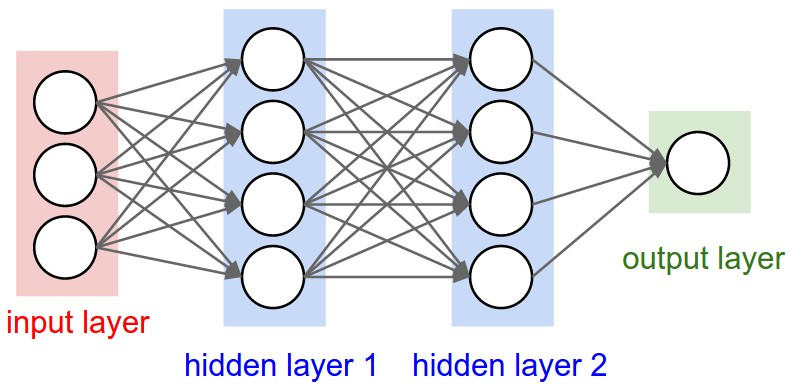

In [20]:
from IPython.display import Image, display
display(Image(filename='mlp.jpeg'))

 But first, let's explore an example for gaining the intuition for doing so: **backprop** through a simplified neuron.

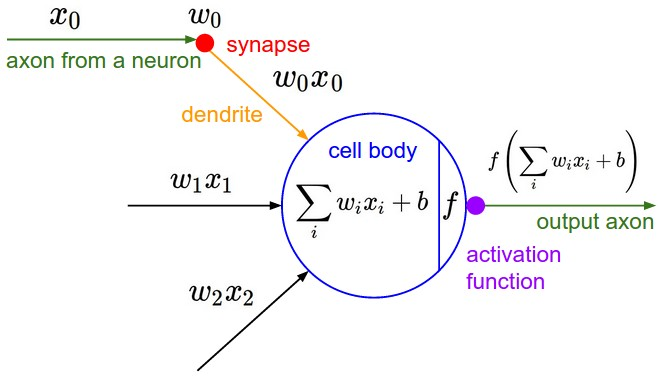

In [21]:
display(Image(filename='neuron.jpeg'))

Such a neuron:
- receives input $w_i x_i$ (output $x_i$ of incoming neuron multiplied by a synaptic weights $w_i$)
- summates those inputs $\displaystyle \sum_i w_i x_i$ at the cell body
- adds a bias $b$
- passes the result through an activation function $f$
- outputs the value $f\bigg(\displaystyle \sum_i w_i x_i + b\bigg)$

An activation function $f$ usually represents a squashing function such as $\tanh$:

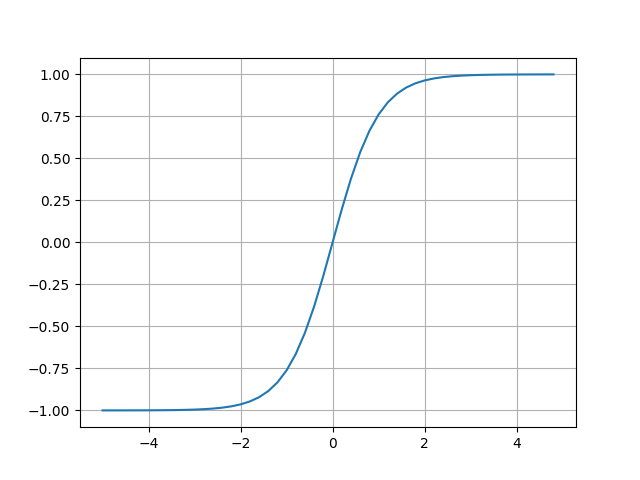

In [22]:
plt.figure()
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid();

Let's extend our `Value` class to incorporate such a `tanh` activation function:

In [23]:
class Value(Value):
    def tanh(self):
        return self.__class__(
            data=math.tanh(self.data),
            prev=(self,),
            op='tanh',
        )

To simulate the functionality of this neuron:

In [24]:
def make_neuron_output():
    global x1, x2, w1, w2, b, x1w1, x2w2, sum_, n, o
    # inputs x1,x2
    x1 = Value(2.0, label='x1')
    x2 = Value(0.0, label='x2')
    # weights w1,w2
    w1 = Value(-3.0, label='w1')
    w2 = Value(1.0, label='w2')
    # bias of the neuron
    b = Value(6.8813735870195432, label='b')
    # x1*w1 + x2*w2 + b
    x1w1 = x1*w1; x1w1.label = 'x1*w1'
    x2w2 = x2*w2; x2w2.label = 'x2*w2'
    sum_ = x1w1 + x2w2; sum_.label = 'x1*w1 + x2*w2'
    n = sum_ + b; n.label = 'n'
    o = n.tanh(); o.label = 'o'  # see the newly implemented Value.tanh method
make_neuron_output()

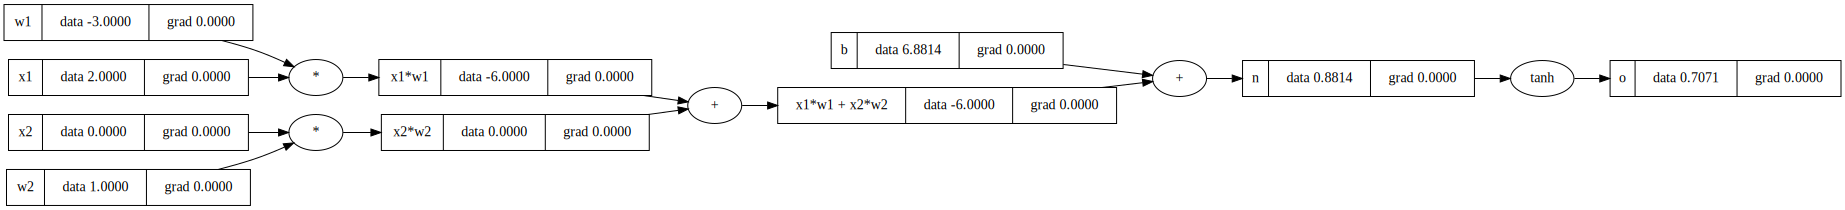

In [25]:
draw(o)

As you can see, this graph represents a neuron that takes inputs and weights and produces a value $n$ squashed by an activation function that outputs $o$. But, the grad attributes are empty. Let's fill them up by doing another manual **backprop**! Doing so requires finding out the derivatives of $o$ w.r.t. the inputs. But of course in a typical **nn** setting what we really care about the most are the derivatives w.r.t. the weights $w_i$ because those are the free parameters that are usually changed when improving performance.

In [26]:
o.grad = 1.0
o.grad

1.0

`do/dn = d(tanh(n))/dn = 1 - tanh(n)**2`, according to [hyperbolic functions derivatives](https://en.wikipedia.org/wiki/Hyperbolic_functions#Derivatives). Therefore:

In [27]:
n.grad = 1 - o.data**2
n.grad

0.4999999999999998

Since we know from before that the `+` operation acts as a gradient router and we can see from our graph that $n$ is recursively preceeded by two `+` operations, the children nodes's `grad` attribute will be the same value as: `n.grad`:

In [28]:
x2w2.grad = x1w1.grad = sum_.grad = b.grad = n.grad
x2w2.grad

0.4999999999999998

And according to the chain rule, as previously described, the derivatives of the inputs w.r.t to the outputs will be:
- `do/dx1 = (do/dx1w1) * (dx1w1/dx1) = (do/dx1w1) * w1`
- `do/dw1 = (do/dx1w1) * (dx1w1/dw1) = (do/dx1w1) * x1`
- `do/dx2 = (do/dx2w2) * (dx2w2/dx2) = (do/dx2w2) * w2`
- `do/dw2 = (do/dx2w2) * (dx2w2/dw2) = (do/dx2w2) * x2`
As such:

In [29]:
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data
print(x1.grad)
print(w1.grad)
print(x2.grad)
print(w2.grad)

-1.4999999999999993
0.9999999999999996
0.4999999999999998
0.0


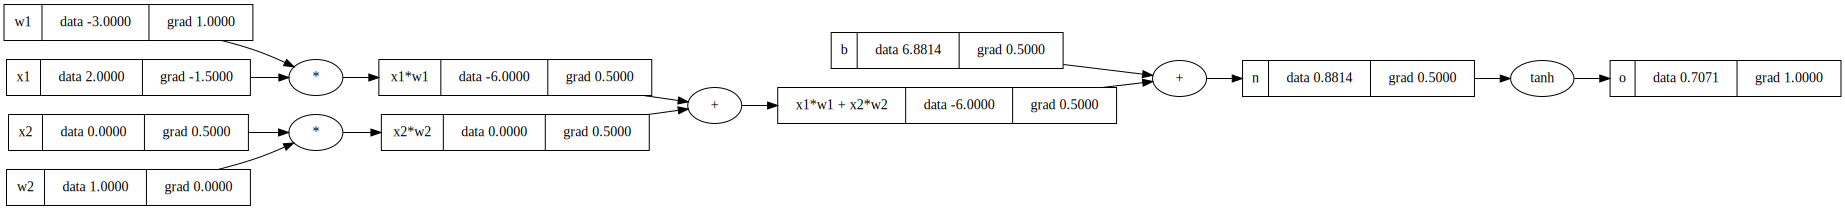

In [30]:
draw(o)

Done. Ok now, doing manual **backprop** is obviously ridiculous. So, we are gonna put an end to our suffering and see how we can do the backward pass automatically by codifying what we have learnt so far. Specifically, inside each operation of a `Value` instance, we will define a `backward` function that calculates each gradient.

In [31]:
class Value(Value):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._backward = lambda: None
    def __add__(self, other):
        other = other if isinstance(other, self.__class__) else self.__class__(other)        
        out = super().__add__(other)
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __mul__(self, other):
        other = other if isinstance(other, self.__class__) else self.__class__(other)        
        out = super().__mul__(other)
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def tanh(self):
        out = super().tanh()
        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward
        return out

Notice: we accumulate each gradient (`+=`) instead of just assigning it (`=`). This guarantees that multiple backward calls on the same node are not overwritten the [multivariable case of the chain rule](https://en.wikipedia.org/wiki/Chain_rule#Multivariable_case). Now, with our enhanced class, let's re-make the neuron's output:

In [32]:
make_neuron_output()

and let's do automatic **backprop** with the help of the `backward` functions we just defined! Calling it on a value node will populate the `grad` attribute of the value nodes that produced it: essentially **backprop**.

In [33]:
o.grad = 1.0  # base case
o._backward()
n._backward()
b._backward()  # leaf node: nothing happens!
sum_._backward()
x2w2._backward()
x1w1._backward()
x2._backward()  # leaf node: nothing happens!
w2._backward()  # leaf node: nothing happens!
x1._backward()  # leaf node: nothing happens!
w1._backward()  # leaf node: nothing happens!

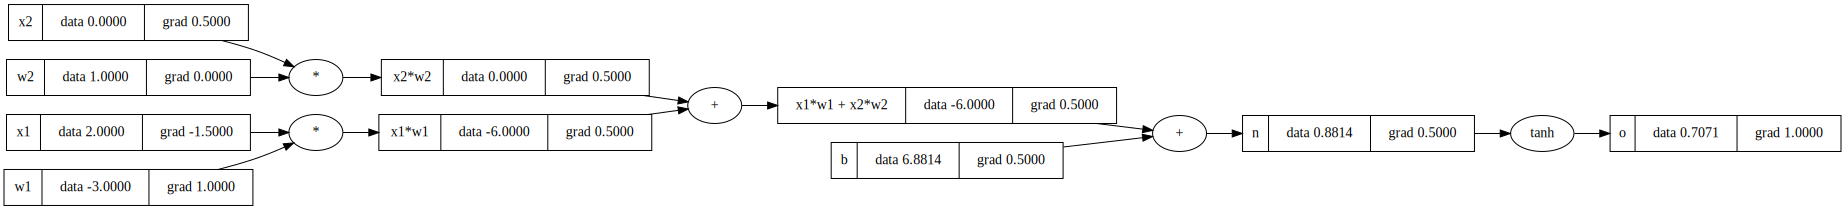

In [34]:
draw(o)

Hurray! We managed to ease the pain of manually calculating the gradients of each node. However, there's a problem: calling `backward` on a node (e.g. `x1w1`) will only work if `backward` has already been called on its descendant node(s) (e.g. `n`). In our graph topology this means that `backward` must be called from rightmost to leftmost nodes. This can be done easily by laying out our graph using [topological sorting](https://en.wikipedia.org/wiki/Topological_sorting). Below, we re-do the forward pass and define a function that does so:

In [35]:
make_neuron_output()
o.grad = 1.0
topo = []
visited = set()
def toposort(v):
    if v not in visited:
        visited.add(v)
        for child in v.prev:
            toposort(child)
        topo.append(v)
toposort(o)
topo

[Value(data='-3.0', label='w1'),
 Value(data='2.0', label='x1'),
 Value(data='-6.0', label='x1*w1'),
 Value(data='1.0', label='w2'),
 Value(data='0.0', label='x2'),
 Value(data='0.0', label='x2*w2'),
 Value(data='-6.0', label='x1*w1 + x2*w2'),
 Value(data='6.881373587019543', label='b'),
 Value(data='0.8813735870195432', label='n'),
 Value(data='0.7071067811865477', label='o')]

Basically, it adds children nodes first before adding non-children nodes. For examples, the child node `b` is first in the resulting list. Whereas, the non-child node `o` is last. In essence, what this sorting allows us to do is to traverse the graph and recursively call `backward` in a safe way, solving the aforementioned problem and facilitating automatic **backprop** with a single call. Like this:

In [36]:
for node in reversed(topo):
    node._backward()

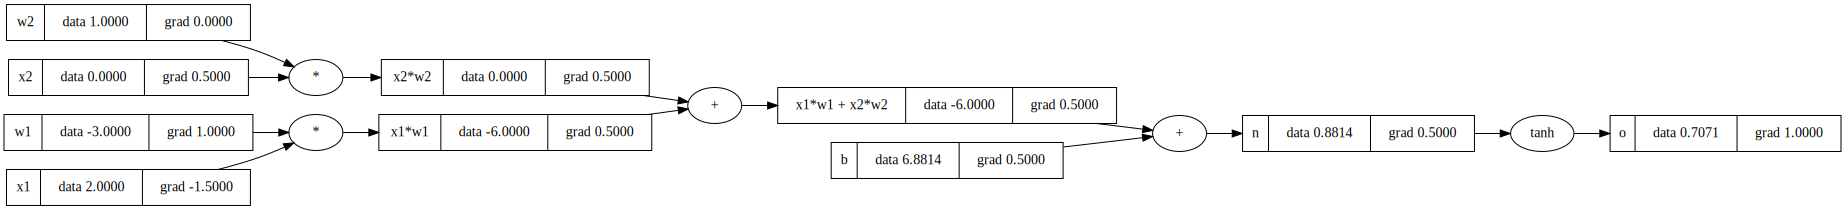

In [37]:
draw(o)

Let's incorporate this feature into our new `Value` class:

In [38]:
class Value(Value):
    def backward(self):
        topo = []
        visited = set()
        def toposort(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    toposort(child)
                topo.append(v)
        toposort(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

To verify it works, we re-make our neuron's output:

In [39]:
make_neuron_output()

and...

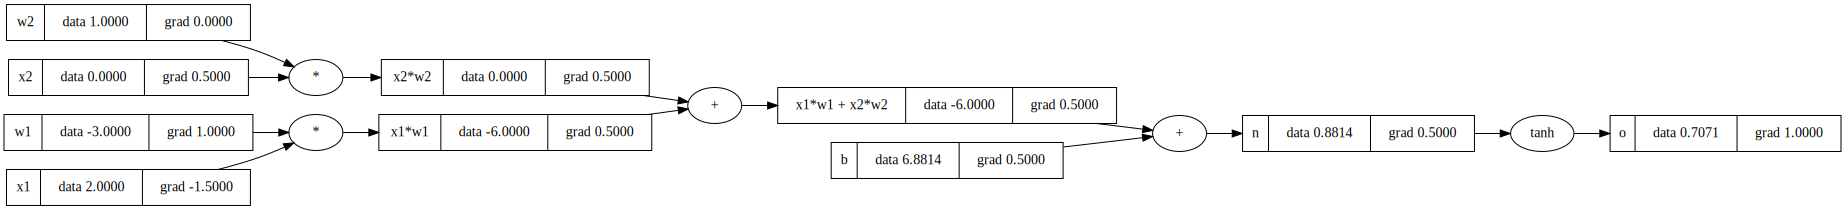

In [40]:
o.backward()
draw(o)

Voilà! **backprop** with a single backward call. Let's test it out one more time:

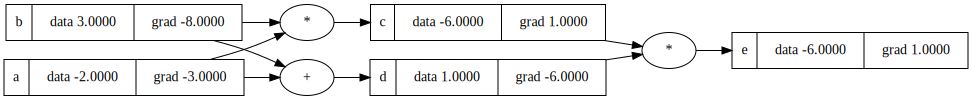

In [41]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
c = a * b; c.label = 'c'
d = a + b; d.label = 'd'
e = d * c; e.label = 'e'
e.backward()
draw(e)

Nice. That was easy... right? Next up, just to prove that this process works more generally, let's exercise by adding a few more complex operations to our `Value` class.

First, a power operation:

In [42]:
class Value(Value):
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = self.__class__(
            data=self.data**other,
            prev=(self,),
            op=f'**{other}',
        )
        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad
        out._backward = _backward
        return out

In [43]:
a = Value(2.0)
b = 3.0
c = a**b
c.grad = 1.0; c._backward()
assert a.grad == b * a.data**(b - 1)

Also, a division operation:

In [44]:
class Value(Value):
    def __truediv__(self, other):  # self / other
        return self * other**-1

In [45]:
a = Value(2.0)
b = Value(4.0)
c = a / b
assert c.data == (a * (1/b.data)).data == (a * b**-1).data
c.grad = 1.0; c._backward()
assert a.grad == 1 / b.data

And last, but not least, an exponentiation operation:

In [46]:
class Value(Value):
    def exp(self):
        out = self.__class__(
            data=math.exp(self.data),
            prev=(self,),
            op='exp',
        )
        def _backward():
            # import ipdb;ipdb.set_trace()
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

In [47]:
a = Value(2.0)
a_exp = a.exp()
a_exp.grad = 1.0; a_exp._backward()
assert a.grad == a_exp.data

Using these newly defined operations, we can now express the [`tanh` operation](https://en.wikipedia.org/wiki/Hyperbolic_functions#Exponential_definitions) as a composite operation, consisting of a combination of those, as follows:

In [48]:
class Value(Value):
    def tanh(self):
        e = (2*self).exp()
        return (e - 1) / (e + 1)

In [49]:
a = Value(2.0)
a_tanh = a.tanh()
a_tanh.backward()
assert math.isclose(a.grad, (1 - a_tanh.data**2))

Furthermore, re-making the neuron output, now  with the new, composite `tanh`, and doing **backprop**

In [50]:
make_neuron_output()
o.backward()

should yield us...

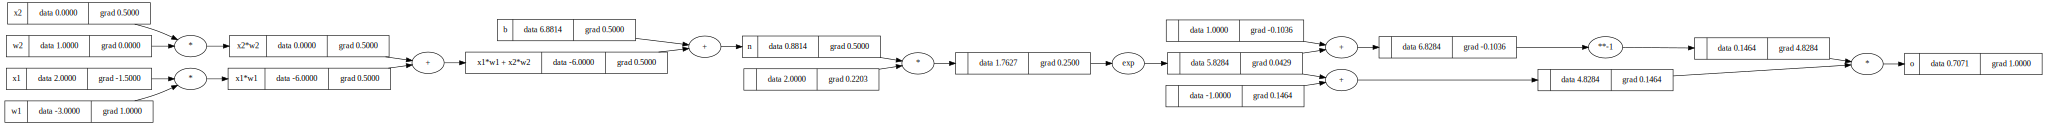

In [51]:
draw(o)

...the same gradients as before! In the end, what matters is being able to do a functional forward pass and backward pass (**backprop**) on the output of any of such operation we have defined, no matter how "composite" it is. If you apply the chain rule properly, as demonstrated, the design of the function and it's complexity are totally up to you. As long as the backward processes are correct, properly, all is good.

So now let's do the exact same thing using a modern deep neural network library, like [pytorch](https://pytorch.org/), on which **micrograd** is roughly modeled.

In [52]:
import torch

In pytorch, the equivalent of our `Value` object is the `Tensor` object. Tensors are just n-dimensional arrays of scalars. Examples:

In [53]:
torch.Tensor([2.])  # 1x1 tensor
torch.Tensor([[1., 2., 3.], [4., 5., 6.]])  # 2x3 tensor

tensor([[1., 2., 3.],
        [4., 5., 6.]])

Like **micrograd**, pytorch let's us construct the mathematical expression of a neuron function on which we can perform **backprop**!

In [54]:
x1 = torch.tensor([2.0]).double().requires_grad_(True)
x2 = torch.tensor([0.0]).double().requires_grad_(True)
w1 = torch.tensor([-3.0]).double().requires_grad_(True)
w2 = torch.tensor([1.0]).double().requires_grad_(True)
b = torch.tensor([6.8813735870195432]).double().requires_grad_(True)
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


`tensor()` makes a tensor, `double()` casts it to a double-precision data type (as does python by default) and `requires_grad_()` set enables gradient calculation for that tensor. In pytorch, one has to explicitly enable it gradient calculation is disabled by default for efficiency reasons. Above, we just use single-element scalar tensors. But the whole point of pytorch is to work with multi-dimensional tensors that can be acted upon in parallel by many different operations. Nevertheless, what we have built very much agrees with the API of pytorch!

Let's now construct the mathematical expression that constitutes a **nn** piece by piece, specifically, a 2-layer **mlp**. We'll start out by writing up a neuron as we've implemented it so far, but making it subscribe to the pytorch API model in how it designs its **nn** modules.

In [55]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

`w` is an array of values that represents the weights of the `nin` input neurons and `b` the bias of this neuron. Now, we are gonna implement the forward pass call: the sum of the products of each `w` and input `x` and bias (`w * x + b`) passed through a non-linear activation function (e.g. `tanh`).

In [56]:
class Neuron(Neuron):
    # w * x + b
    def __call__(self, x):
        act = sum((w * x for w, x in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

Here's an example of passing two inputs `x` through the neuron:

In [57]:
x = [2.0, 3.0]
nin = len(x)
n = Neuron(nin)
n(x)

Value(data='-0.9628049997002368')

Having done so, let's create a `Layer` object that represents a layer composed of many neurons as in typical **nn** fashion. It takes the number of input and output neurons (`nin`, `nout`) as arguments.

In [58]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

Here's an example of passing two inputs `x` through a layer of neurons:

In [59]:
x = [2.0, 3.0]
nin = len(x)
nout = 3
l = Layer(nin, nout)
l(x)

[Value(data='0.9948134787964437'),
 Value(data='0.9991929770528765'),
 Value(data='0.7191612357476502')]

As expected, after passing in `nin` input values, we get `nout` output values.

Finally, we'll implement an **mlp**, in which layers basically feed into each other sequentially. First, we define a constructor that creates a list of layers, each one initialized with the proper number of inputs and outputs, given an initial `nin` and `nouts` list. Then, a forward pass method that passes an initial input `x` through each of the layers, from first to last.

In [60]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

Here's an example reconstructing the [mlp example](#MLP-example) we saw previously. It has 3 input neurons, two hidden 4-neuron layers and a 1-neuron output layer, therefore:

In [61]:
def define_mlp():
    return MLP(3, [4, 4, 1])
mlp = define_mlp()
x = [2.0, 3.0, -1.0]
mlp_out = mlp(x)
mlp_out

Value(data='-0.6959357704004752')

And if we draw our single **mlp** output...

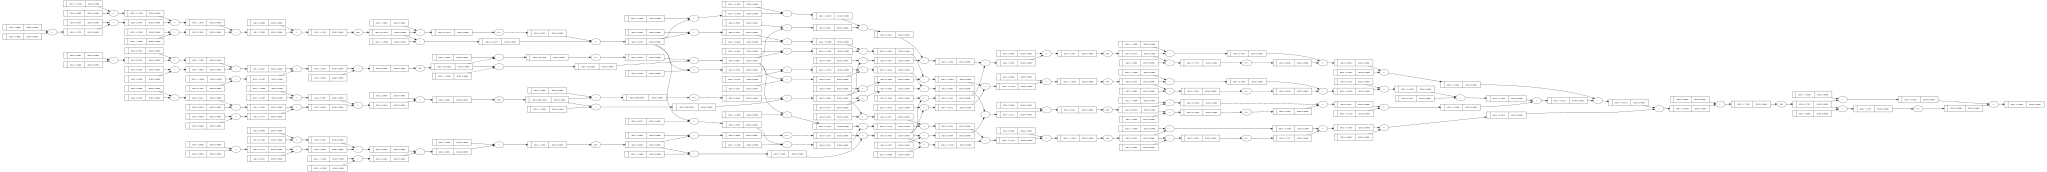

In [62]:
draw(mlp_out)

Wow! That's a big graph! Now obviously, no one sane enough would dare differentiate these expressions with pen and paper. But with **micrograd** you'll be able to **backprop** all the way through this back into the leaf nodes, meaning the weights of our neurons (`Neuron.w`).

To test it out, let's define our own inputs dataset (`xs`) to be fed into our **mlp**, as well as their corresponding target values `ys`. Basically, a simple binary classifier **nn**, since input corresponds to either `1.0` or `-1.0`.

In [63]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

Each one of the input vectors corresponds to each target value of `y`. E.g. `[2.0, 3.0, -1.0]` corresponds to target `1.0`, `[3.0, -1.0, 0.5]` to `-1.0`, and so on. Now, `ys` are the *desired* values. Now, let's pass `xs` through our **mlp** and get the predicted values `ypred`:

In [64]:
def forward_pass_mlp(mlp):
    return [mlp(x) for x in xs]
ypreds = forward_pass_mlp(mlp)
ypreds

[Value(data='-0.6959357704004752'),
 Value(data='-0.42074563070875065'),
 Value(data='-0.574318996080075'),
 Value(data='-0.6463163223747307')]

As you can see, currently, our **mlp** outputs values (`ypreds`) that are different from the desired target values we want (`ys`). So, how do we make `ypreds` equal, or at least as close as possible, to `ys`? Specifically, how do we tune the weights (aka, train our **nn** **w.r.t.** them) in order to better predict the desired targets? The trick used in deep learning that helps us achieve this, is to calculate a single number that somehow measures how well the **nn** is performing. This number is called the **loss**. Right now, `ypred` is not close to `ys`, so we are not perfoming very well, meaning that the **loss** value is high. Our goal is to minimize the **loss** value and, by doing so, bring each `ypred` closer to its corresponding `y`. One way to calculate the **loss** value is through the mean squared error (**MSE**) function. This function will iterate over pairs of `ys` and `ypreds` and sum the squares of their differences.

The squared difference of two values (e.g. a prediction and target value) discards any negative signs and gives us a positive quantification that represents how they those values differ, aka their **loss**. If the **loss** is zero, the two values do not differ and are equal. Whereas if the **loss** is another, non-zero number, the two values are different and unequal. In general, the more two values differ, the greater their **loss** will be. The less they differ, the lower their **loss** will be. The final **MSE** **loss** of all such pairs will just be the sum of all the squared differences:

In [65]:
def calc_loss(ypreds, ys):
    return sum([(ypred - y)**2 for ypred, y in zip(ypreds, ys)])
loss = calc_loss(ypreds, ys)

Now we want to minimize the **loss**, because if teh **loss** is low, then every one of the predictions is equal to its target. The lowest the **loss** value can be is `0` (the ideal value), whereas the greater it is, the worse off the **nn** is predicting. How do we minimize the **loss**? First, **backprop**!

In [66]:
loss.backward()

After doing a backward call, something magical happened! All gradients of the **loss** **w.r.t.** weights of our **mlp** were calculated. To see this with our eyes, let's print out the `grad` attribute of any of the weights, e.g.:

In [67]:
mlp.layers[0].neurons[0].w[0].grad

-0.24124956779266443

We see that because the gradient of this particular weight of this particular neuron of this particular layer of our **nn** is negative, we see that its influence on the **loss** is also negative. Which means, that slightly increasing this particular weight, would make the **loss** value go down. Now if we draw the **loss**...

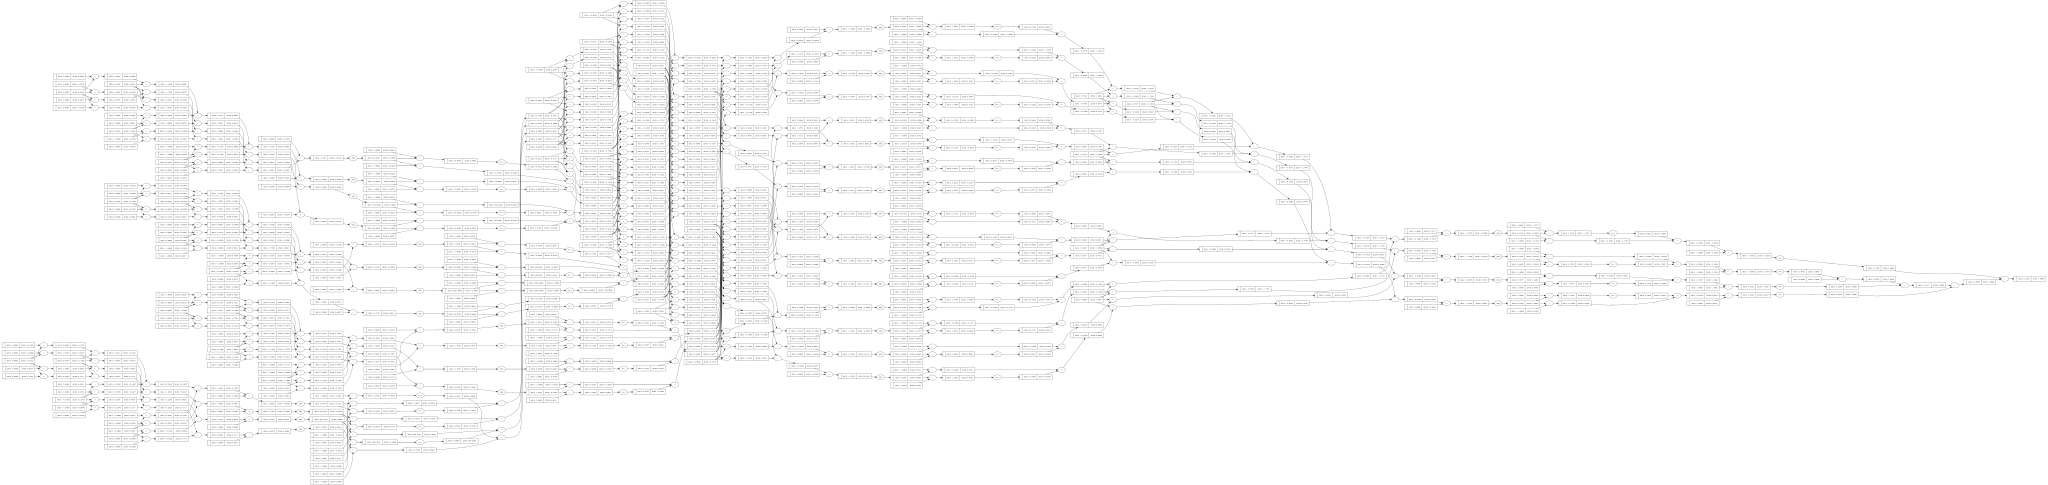

In [68]:
draw(loss)

we see that it's MASSIVE! The reason is that the loss depends on all the values produced by the forward passing all the `x` values contained in `xs` into the **mlp**. Now, although the gradients of all the values in the graph have been calculated, we only care about the gradients of the parameters we want to change, namely the weights and biases. So, our next steps are to gather those parameters and tune them by nudging them based on their gradient information. To do so, we first extend the **mlp** component classes by implementing parameters getter methods:

In [69]:
class Neuron(Neuron):  
    def parameters(self):
        return self.w + [self.b]
class Layer(Layer):  
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP(MLP):
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

After getting our output and loss again (due to redefining the classes)...

In [70]:
mlp = define_mlp()
ypreds = forward_pass_mlp(mlp)
loss = calc_loss(ypreds, ys)
loss.backward()

we may inspect all the parameters...

In [71]:
mlp_params = mlp.parameters()
print(mlp_params)
print(len(mlp_params))

[Value(data='0.019944358300538978'), Value(data='0.6564772221404693'), Value(data='-0.9439888769992182'), Value(data='0.2079645404726702'), Value(data='-0.1163541736565108'), Value(data='-0.2866519242637371'), Value(data='0.12971406411167896'), Value(data='0.6878883516110466'), Value(data='-0.910286707473368'), Value(data='0.9785776625805773'), Value(data='0.7038470426397108'), Value(data='-0.5533931495419553'), Value(data='-0.08033211799734064'), Value(data='0.7114779685492316'), Value(data='-0.3431417305038065'), Value(data='-0.11357408796333757'), Value(data='-0.7112668040161894'), Value(data='-0.9885564073041202'), Value(data='-0.22889834221471594'), Value(data='0.6267619056293516'), Value(data='-0.1878419970150762'), Value(data='-0.25915013872366144'), Value(data='0.6591046988761828'), Value(data='-0.8126926586257621'), Value(data='-0.7572491534154926'), Value(data='-0.376126495737239'), Value(data='0.32277419570093313'), Value(data='0.35183310571706206'), Value(data='-0.677896723

and change them in a manner that decreases the loss. Before we optimize all of them though, let's first optimize only one to see exactly how the process is done:

In [72]:
mlp.layers[0].neurons[0].w[0].grad

2.678027964901503

In [73]:
mlp.layers[0].neurons[0].w[0].data

0.019944358300538978

To understand how to optimize the parameters, let's understand th relationship between `grad` and **loss** through the two distinct cases.

**A**. A positive parameter `grad` (`>0`) value tells us that:
- (**1**) *increasing* that parameter would *increase* the **loss**
- (**2**) *decreasing* that parameter would *decrease* the **loss**

**B**. A negative parameter `grad` (`<0`) value tells us that:
- (**1**) *increasing* that parameter would *decrease* the **loss**
- (**2**) *decreasing* that parameter would *increase* the **loss**

Since, we only care about *decreasing* the **loss** (since we want to minimize it), we only care about cases **A2** and **B1**. Therefore, we now know that *decreasing* the **loss** depends on changing the weight by an amount whose sign is the opposite of the `grad` value. Since the opposite of a value is just it's negation, we describe the general optimization step required to change each parameter as follows:

> To decrease the **loss**, change each parameter `p` in the direction that is opposite the direction of the the gradient `grad` of the **loss**.

This can be achieved by subtracting the product of the gradient and a small step size `α` from the current parameter value:
`p = p - α * grad`, where `α` is a usually small positive number (e.g. `0.001`) called the learning rate, which determines how big of a step size is taken during each optimization step. Since we descend the gradient, we call this process gradient descent. Let's now optimize one weight parameter with one step of gradient descent:

In [74]:
ypreds = forward_pass_mlp(mlp)
loss = calc_loss(ypreds, ys)
# zero gradients (so they don't accummulate)
for p in mlp.parameters():
    p.grad = 0.0
loss.backward()
mlp.layers[0].neurons[0].w[0].data += -0.001 * mlp.layers[0].neurons[0].w[0].grad
ypreds_after = forward_pass_mlp(mlp)
loss_after = calc_loss(ypreds_after, ys)
print(f'Loss before optimization step: {loss}')
print(f'Loss after optimization step: {loss_after}')

Loss before optimization step: Value(data='6.455885406704282')
Loss after optimization step: Value(data='6.448754004498043')


See? Loss after the step is lower than before it. So, optimizing even one parameter with this procedure, decreases the **loss** of our **mlp**! But in order to decrease it even more, let alone minimize it, we must also optimize all of the parameters. How? Like this:

In [75]:
ypreds = forward_pass_mlp(mlp)
loss = calc_loss(ypreds, ys)
# zero gradients (so they don't accummulate)
for p in mlp.parameters():
    p.grad = 0.0
loss.backward()
for p in mlp.parameters():
    p.data += -0.001 * p.grad
ypreds_after = [mlp(x) for x in xs]
loss_after = sum([(ypred - y)**2 for ypred, y in zip(ypreds_after, ys)])
print(f'Loss before optimization step: {loss}')
print(f'Loss after optimization step: {loss_after}')
print([y.data for y in ypreds])
print([y.data for y in ypreds_after])
print(ys)

Loss before optimization step: Value(data='6.448754004498043')
Loss after optimization step: Value(data='6.3202145985971985')
[-0.8810451741134457, 0.25017480892481286, -0.7247074921234207, -0.1276967853458618]
[-0.8723714717460451, 0.23254422355872698, -0.7224881695230954, -0.10374888054580592]
[1.0, -1.0, -1.0, 1.0]


Same thing happens: **loss** decreases! Most importantly, each time we re-run the optimization, the prediction values get even closer to the target values, which is our primary goal! In general, we must be careful with our step size. Too small of a step size will take many many steps to decrease the **loss**, whereas too big of a step size might be an *overstep* that causes an increase instead of a decrease of the **loss**. Sometimes, if the increase is too big, the **loss** value explodes. Finding a step size that is just right can be a subtle art sometimes. You can play around with the step size, re-running the cells each time, to see its effect. All in all, we have being able to derive a set of parameters (weights and biases):

In [76]:
mlp.parameters()

[Value(data='0.014618499140776613'),
 Value(data='0.6573975056491442'),
 Value(data='-0.9447988563410392'),
 Value(data='0.20704771264934213'),
 Value(data='-0.11668450788817228'),
 Value(data='-0.2805790133064697'),
 Value(data='0.12542544246024506'),
 Value(data='0.6895875072047933'),
 Value(data='-0.9111136286282762'),
 Value(data='0.9775048113536753'),
 Value(data='0.7044947287787015'),
 Value(data='-0.5539238248531219'),
 Value(data='-0.08009628806680945'),
 Value(data='0.7102927083757891'),
 Value(data='-0.34186951499686724'),
 Value(data='-0.11396744823562892'),
 Value(data='-0.7142413518424132'),
 Value(data='-0.9876238839437889'),
 Value(data='-0.22880869208993798'),
 Value(data='0.6240282076966629'),
 Value(data='-0.18848177663943125'),
 Value(data='-0.2584644635315741'),
 Value(data='0.6590951568962039'),
 Value(data='-0.8131286581485717'),
 Value(data='-0.756716574306988'),
 Value(data='-0.3756347555007946'),
 Value(data='0.32590169669302627'),
 Value(data='0.35073278207407

that makes our network predict the target values. Basically, we have learned how to train a **nn**! But, let's make it a bit more respectable by implementing a training loop.

In [77]:
for k in range(20):
    # forward pass
    ypreds = forward_pass_mlp(mlp)
    loss = calc_loss(ypreds, ys)
    # zero gradients (so they don't accummulate)
    for p in mlp.parameters():
        p.grad = 0.0
    # backward pass
    loss.backward()
    # update
    for p in mlp.parameters():
        p.data += -0.05 * p.grad
    print(k, loss.data)

0 6.3202145985971985
1 0.7687452525744509
2 0.36296008320578615
3 0.24123116608218576
4 0.17747043462926718
5 0.1386375027805196
6 0.11288645351493136
7 0.09472936109359667
8 0.08132095993971059
9 0.07105748844352078
10 0.0629736716017395
11 0.056457062342646455
12 0.05110192483929975
13 0.046629631090677484
14 0.042842950721473594
15 0.03959860902136124
16 0.036790173254157385
17 0.03433702317743158
18 0.03217703587646587
19 0.030261610124369072


After training, prediction values should be significantly closer to target values:

In [78]:
print([y.data for y in ypreds])
print(ys)

[0.8939017667094021, -0.9492651410315439, -0.9136146282233278, 0.9052988033579303]
[1.0, -1.0, -1.0, 1.0]


Let's now bring together and summarize what we have learned. **nn**s are functions that take the data as well as the weights and biases (parameters) as inputs to produce outputs. The outputs, or `predictions`, together with target values are then passed through a **loss** function that yields a **loss** value that represents their distance in terms of close or far apart they are. We train **nn**s by using **backprop** to calculate the gradient of the **loss** **w.r.t.** the parameters. These gradients are used to then optimize those parameters using gradient descent in order to minimize the **loss**. The end goal is for the **nn** to perform a given task. Although relatively simple expressions, it turns out that **nn**s can solve very complicated problems. Sometimes, if the problem is complex enough, and the **nn** big enough (100 billion+ parameters), fascinating proprties arise, as in the case of [GPT](https://en.wikipedia.org/wiki/Generative_pre-trained_transformer), for example. This model, trained with amounts of texts from the internet can predict, given some words, the next words in a sequence.

This brings us to the end of the [micrograd tutorial](#1.-micrograd). I hope you enjoyed this tutorial and found it helpful! For more (tests, demo, etc.), see the [original micrograd repository](https://github.com/karpathy/micrograd).

Now it's time to *make more*.